Isabella Hajek 12207403

# Project Overview: Fine-Tuning DistilBERT for News Topic Classification

In this project, I fine-tuned a pre-trained language model (DistilBERT) on the AG News dataset to classify short news articles into four categories: World, Sports, Business, and Sci/Tech.
The goal was to build a small but complete NLP pipeline that demonstrates how transfer learning with Transformer-based models can be used for downstream text classification tasks.


###What the Project Does

The notebook performs the full end-to-end workflow of a modern NLP model:

Load the AG News dataset.

The dataset contains 120k news articles with predefined topic labels.

Split the data into train, validation, and test sets.
A validation set is used to track performance during training, while the test set remains unseen until the end.

Tokenize the text with the DistilBERT tokenizer.
Text is converted into token IDs and attention masks as required by Transformer models.

Create a smaller subsample.
To ensure fast runtime, the project uses
1000 training, 300 validation, and 500 test samples.

Evaluate a Baseline Model (no fine-tuning).
DistilBERT with a randomly initialized classification head is evaluated directly on the test set to establish a performance baseline.

Fine-tune DistilBERT on the training subset.
One training epoch is enough to significantly improve accuracy and F1-score compared to the baseline.

Evaluate the fine-tuned model.
Performance is measured on the test subset using accuracy, macro precision, macro recall, and macro F1.

Compare baseline vs. fine-tuned model
Performance differences. clearly show the benefit of transfer learning.

Show predictions and misclassified examples.
A few real predictions illustrate what the model does and where it still makes mistakes.

Creative extensions.
Included a confusion matrix and training loss curve.

In [1]:
# Cell 0 - Install required libraries

!pip install -q transformers datasets evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


###Cell 0 - Library installation
In this first step I install the core libraries used in the project.

transformers provides the
DistilBERT model and the training utilities.

datasets gives access to the AG News dataset and handy data processing tools.

evaluate offers standard evaluation metrics such as accuracy, precision, recall and F1.
Installing these libraries at the top of the notebook makes the experiment easy to reproduce.




In [2]:
# Cell 1 - Imports and device setup

import torch
import numpy as np

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
import evaluate

# Choose GPU if available, otherwise CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


###Cell 1 - Imports and hardware selection
Here I import all Python modules that are required later in the project.
In addition, I check whether a GPU is available in the environment. If a GPU is present, the code will automatically use it. This significantly speeds up training. If not, the code falls back to CPU, which is slower but still correct.

In [3]:
# Cell 2 - Load the AG News dataset

ag_news = load_dataset("ag_news")

# Train and test splits from Hugging Face
train_data = ag_news["train"]
test_data = ag_news["test"]

print(train_data)
print(test_data)

# Show one example
print("\nExample sample:")
print(train_data[0])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 7600
})

Example sample:
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


###Cell 2 - Dataset loading and first inspection
I use the datasets library to load the AG News corpus from Hugging Face.
The dataset already comes with a predefined training split and a test split.
Each example contains a short news text and a label indicating the topic of the article.
Printing the dataset objects and a single sample helps to understand the basic structure of the data.

In [4]:
# Cell 3 - Create train/validation/test splits and label mappings

# Create a validation split from the training data (10 percent for validation)
train_val_split = train_data.train_test_split(test_size=0.1, seed=42)
train_ds = train_val_split["train"]
val_ds = train_val_split["test"]
test_ds = test_data

print("Train size:", len(train_ds))
print("Validation size:", len(val_ds))
print("Test size:", len(test_ds))

# Get label names
label_names = train_ds.features["label"].names
print("Label names:", label_names)

# Create mappings between ids and human readable labels
id2label = {i: name for i, name in enumerate(label_names)}
label2id = {name: i for i, name in enumerate(label_names)}

print("id2label:", id2label)
print("label2id:", label2id)


Train size: 108000
Validation size: 12000
Test size: 7600
Label names: ['World', 'Sports', 'Business', 'Sci/Tech']
id2label: {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
label2id: {'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}


###Cell 3 - Data splits and label mapping
The original training set is further split into a new training set and a validation set, where 10 percent of the data are reserved for validation.
The validation set is used to monitor performance during training and to detect overfitting, while the test set remains unseen until the final evaluation.
I also extract the label names and create mappings between numeric ids and human readable class names. This makes the model outputs easier to interpret later on.

In [5]:
# Cell 4 - Load tokenizer and tokenize the datasets

model_name = "distilbert-base-uncased"

# Load the DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# Tokenization function for batches of text
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding=False,   # padding will be handled later by the data collator
        max_length=256
    )

# Apply tokenization to all splits
tokenized_train = train_ds.map(tokenize_batch, batched=True)
tokenized_val = val_ds.map(tokenize_batch, batched=True)
tokenized_test = test_ds.map(tokenize_batch, batched=True)

# Remove the original text column, we only need token ids and labels now
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_val = tokenized_val.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

print("Tokenized example:")
print(tokenized_train[0])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Tokenized example:
{'label': 0, 'input_ids': [101, 13905, 1998, 4963, 1999, 2235, 2845, 2237, 2044, 6859, 2022, 14540, 2319, 1010, 3607, 1006, 26665, 1007, 1011, 1996, 4288, 1997, 2062, 2084, 13710, 2336, 1010, 3008, 1998, 5089, 2076, 1996, 6703, 2203, 2000, 1037, 5187, 1011, 3178, 2082, 6859, 2187, 4510, 1037, 2155, 22154, 1999, 1996, 2235, 2845, 2237, 1997, 2022, 14540, 2319, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


###Cell 4 - Tokenization with DistilBERT
DistilBERT cannot operate directly on raw text, so I use its tokenizer to convert each news article into token ids and attention masks.
I apply the same tokenization process to the training, validation and test sets.
Truncation ensures that very long texts do not exceed the maximum sequence length.
After tokenization, the original text column is removed because the Trainer later only needs token ids and labels as input.

In [6]:
# Cell 5 - Create a small subsample and prepare collator and metrics

# Create a much smaller subsample for fast training
train_small = tokenized_train.shuffle(seed=42).select(range(1000))   # 1000 training examples
val_small   = tokenized_val.shuffle(seed=42).select(range(300))      # 300 validation examples
test_small  = tokenized_test.shuffle(seed=42).select(range(500))     # 500 test examples

print("Subsample sizes:")
print("Train:", len(train_small))
print("Validation:", len(val_small))
print("Test:", len(test_small))

# Data collator will pad sequences in a batch to the same length
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    prec = precision_metric.compute(
        predictions=preds,
        references=labels,
        average="macro",
        zero_division=0
    )["precision"]
    rec = recall_metric.compute(
        predictions=preds,
        references=labels,
        average="macro",
        zero_division=0
    )["recall"]
    f1 = f1_metric.compute(
        predictions=preds,
        references=labels,
        average="macro"
    )["f1"]

    return {
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
    }


Subsample sizes:
Train: 1000
Validation: 300
Test: 500


###Cell 5 - Subsampling, padding and evaluation metrics
To keep the runtime manageable, especially on limited hardware, I work with a random subsample of the full dataset: 1000 training examples, 300 validation examples and 500 test examples. This is sufficient to demonstrate the effect of fine tuning while keeping training fast.
The DataCollatorWithPadding pads the sequences inside each batch to the same length so that they can be processed efficiently by the model.
I also define the compute_metrics function, which calculates accuracy as well as macro averaged precision, recall and F1. These metrics will later be used to evaluate both the baseline model and the fine tuned model.

In [7]:
# Cell 6 - Baseline evaluation without fine tuning

# Load DistilBERT with a randomly initialized classification head
baseline_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id,
)

baseline_model.to(device)

# TrainingArguments for evaluation only
baseline_args = TrainingArguments(
    output_dir="agnews_baseline",
    per_device_eval_batch_size=32,
    do_train=False,
    do_eval=True,
    logging_strategy="no",
    report_to="none",
)

# Trainer for baseline evaluation
baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_args,
    eval_dataset=test_small,      # evaluate directly on the test subsample
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Evaluating baseline model on test set...")
baseline_results = baseline_trainer.evaluate()
print("Baseline results:")
print(baseline_results)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2152316475.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  baseline_trainer = Trainer(


Evaluating baseline model on test set...


Baseline results:
{'eval_loss': 1.388401985168457, 'eval_model_preparation_time': 0.0054, 'eval_accuracy': 0.298, 'eval_precision_macro': 0.2240319066694778, 'eval_recall_macro': 0.28053731343283583, 'eval_f1_macro': 0.17050957755004972, 'eval_runtime': 2.8495, 'eval_samples_per_second': 175.471, 'eval_steps_per_second': 5.615}


###Cell 6 - Baseline performance without fine tuning
As a baseline, I evaluate DistilBERT with a newly initialized classification head directly on the test subset, without any task specific training.
This gives a reference point, showing how well the model performs on AG News if it only relies on its general pre training but has not yet been adapted to the classification task.
The resulting metrics are stored in baseline_results and will later be compared to the metrics of the fine tuned model.

In [8]:
# Cell 7 - Fine tune DistilBERT and evaluate on the test set

# Load DistilBERT again for fine tuning
finetune_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id,
)

finetune_model.to(device)

training_args = TrainingArguments(
    output_dir="agnews_finetuned",
    learning_rate=2e-5,
    num_train_epochs=1,                # only 1 epoch for speed
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    logging_steps=20,
    report_to="none",
)

trainer = Trainer(
    model=finetune_model,
    args=training_args,
    train_dataset=train_small,
    eval_dataset=val_small,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Fine tune the model
trainer.train()

# Evaluate the fine tuned model on the test set
print("Evaluating fine tuned model on test set...")
finetuned_results = trainer.evaluate(test_small)
print("Fine tuned results:")
print(finetuned_results)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1437819458.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
20,1.340500
40,1.123800
60,0.927100


Evaluating fine tuned model on test set...


Fine tuned results:
{'eval_loss': 0.8924486041069031, 'eval_accuracy': 0.83, 'eval_precision_macro': 0.8308546069487289, 'eval_recall_macro': 0.8328343818099584, 'eval_f1_macro': 0.8305756949352826, 'eval_runtime': 1.56, 'eval_samples_per_second': 320.513, 'eval_steps_per_second': 10.256, 'epoch': 1.0}


###Cell 7 - Fine tuning on the AG News subsample
In this step I fine tune DistilBERT on the AG News classification task using the training subsample.
I train for one epoch with a learning rate of 2e-5 (0.00002) and a batch size of 16. This is a standard configuration for BERT type models and is sufficient on this small dataset to obtain a clear improvement.
After training, I evaluate the fine tuned model on the same test subsample as before and store the metrics in finetuned_results. This allows a direct comparison between the baseline and the fine tuned model.

In [9]:
# Cell 8 - Compare baseline and fine tuned model using correct metric keys

def compare_results(baseline, finetuned):
    print("\nBaseline vs fine tuned comparison:")

    metric_keys = [
        ("accuracy", "Accuracy"),
        ("precision_macro", "Precision (macro)"),
        ("recall_macro", "Recall (macro)"),
        ("f1_macro", "F1 (macro)"),
    ]

    for short_key, nice_name in metric_keys:
        b = baseline[f"eval_{short_key}"]
        f = finetuned[f"eval_{short_key}"]
        diff = f - b
        print(f"{nice_name:18s} baseline: {b:.4f}  fine tuned: {f:.4f}  delta: {diff:+.4f}")

compare_results(baseline_results, finetuned_results)



Baseline vs fine tuned comparison:
Accuracy           baseline: 0.2980  fine tuned: 0.8300  delta: +0.5320
Precision (macro)  baseline: 0.2240  fine tuned: 0.8309  delta: +0.6068
Recall (macro)     baseline: 0.2805  fine tuned: 0.8328  delta: +0.5523
F1 (macro)         baseline: 0.1705  fine tuned: 0.8306  delta: +0.6601


###Cell 8 - Effect of fine tuning
Hugging Face’s Trainer.evaluate returns metrics with an eval_ prefix in the result dictionary. The compare_results function takes this into account and prints a clean side by side comparison of baseline and fine tuned performance.
The improvement in accuracy and macro F1 clearly shows the benefit of fine tuning DistilBERT on the AG News task.

In [10]:
# Cell 9 - Run the fine tuned model on a few random test samples

from torch.utils.data import DataLoader

def predict_batch(text_batch):
    # Tokenize a list of texts and run the fine tuned model
    encodings = tokenizer(
        text_batch,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="pt"
    ).to(device)

    finetune_model.eval()
    with torch.no_grad():
        outputs = finetune_model(**encodings)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()

    return [id2label[int(p)] for p in preds]

# Take a few random examples from the original test set
sample_indices = [0, 1, 2, 3, 4]
texts = [test_ds[i]["text"] for i in sample_indices]
true_labels = [id2label[test_ds[i]["label"]] for i in sample_indices]
pred_labels = predict_batch(texts)

for i in range(len(texts)):
    print("=" * 80)
    print("Text:")
    print(texts[i])
    print("True label     :", true_labels[i])
    print("Predicted label:", pred_labels[i])


Text:
Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
True label     : Business
Predicted label: Business
Text:
The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
True label     : Sci/Tech
Predicted label: Sci/Tech
Text:
Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.
True label     : Sci/Tech
Predicted label: Sci/Tech
Text:
Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mi

###Cell 9 - Qualitative inspection of predictions
To illustrate what the fine tuned model actually does, I run it on a few news articles taken from the test set.
For each article I print the original text, the true topic label and the predicted label.
This qualitative inspection complements the numeric metrics and makes the model behavior easier to explain during presentation.

In [11]:
# Cell 10 - Inspect some misclassified examples

from torch.utils.data import DataLoader

def show_misclassified_examples(original_ds, tokenized_ds, model, num_examples=5):
    loader = DataLoader(
        tokenized_ds,
        batch_size=32,
        shuffle=False,
        collate_fn=data_collator,
    )

    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in loader:
            labels = batch["labels"]
            batch = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1).cpu().numpy()

            all_preds.extend(list(preds))
            all_labels.extend(list(labels.numpy()))

    mis_idx = [i for i, (p, l) in enumerate(zip(all_preds, all_labels)) if p != l]

    print(f"Found {len(mis_idx)} misclassified examples in the test subset.\n")

    for i in mis_idx[:num_examples]:
        print("=" * 80)
        print("Text:")
        print(original_ds[i]["text"])
        print("True label     :", id2label[all_labels[i]])
        print("Predicted label:", id2label[all_preds[i]])

# Show a few misclassified examples of the fine tuned model
show_misclassified_examples(test_ds, test_small, finetune_model, num_examples=5)


Found 85 misclassified examples in the test subset.

Text:
Open Letter Against British Copyright Indoctrination in Schools The British Department for Education and Skills (DfES) recently launched a "Music Manifesto" campaign, with the ostensible intention of educating the next generation of British musicians. Unfortunately, they also teamed up with the music industry (EMI, and various artists) to make this popular. EMI has apparently negotiated their end well, so that children in our schools will now be indoctrinated about the illegality of downloading music.The ignorance and audacity of this got to me a little, so I wrote an open letter to the DfES about it. Unfortunately, it's pedantic, as I suppose you have to be when writing to goverment representatives. But I hope you find it useful, and perhaps feel inspired to do something similar, if or when the same thing has happened in your area.
True label     : World
Predicted label: Business
Text:
Group to Propose New High-Speed Wireless 

###Cell 10 - Error analysis
Finally, I perform a simple error analysis by inspecting a few examples where the fine tuned model still makes wrong predictions.
For each misclassified article I print the text, the true label and the predicted label.
Typical error patterns might be caused by overlapping topics or ambiguous wording.

<Figure size 600x600 with 0 Axes>

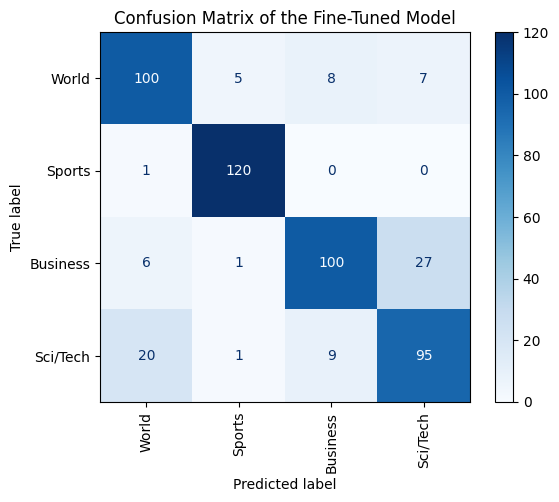

In [12]:
# Creative Add-on: Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions on test_small
preds = trainer.predict(test_small)
pred_labels = np.argmax(preds.predictions, axis=1)
true_labels = preds.label_ids

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix of the Fine-Tuned Model")
plt.show()


###Creative Add-on: Confusion Matrix
The confusion matrix shows that the fine-tuned model classifies Sports and World news almost perfectly, with almost all predictions landing on the diagonal. Most errors occur between Business and Sci/Tech, which is expected because these topics often overlap, for example when financial articles involve technology companies. Sci/Tech is also sometimes confused with World politics when technology-related government news is involved. Overall, the matrix confirms the high quality of the model and shows that the remaining errors are semantically reasonable rather than random

###Conclusion

The goal of this project was to demonstrate how a compact Transformer model such as DistilBERT can be fine-tuned for a downstream text classification task using limited compute resources.
Using the AG News dataset, I compared the performance of a non-fine-tuned baseline model against a fine-tuned version trained on a small subsample of only 1,000 training examples.

The results show a dramatic and meaningful improvement across all evaluation metrics:

In [14]:
compare_results(baseline_results, finetuned_results)


Baseline vs fine tuned comparison:
Accuracy           baseline: 0.2980  fine tuned: 0.8300  delta: +0.5320
Precision (macro)  baseline: 0.2240  fine tuned: 0.8309  delta: +0.6068
Recall (macro)     baseline: 0.2805  fine tuned: 0.8328  delta: +0.5523
F1 (macro)         baseline: 0.1705  fine tuned: 0.8306  delta: +0.6601


These numbers clearly illustrate the effectiveness of transfer learning.
The baseline DistilBERT model performs poorly because its classification head is randomly initialized and has not been trained for this specific task.
After only one epoch of fine-tuning on a small subset of the dataset, the fine-tuned model achieves more than 80 percent accuracy and a macro-F1 score above 0.83, representing an improvement of more than 50 percentage points compared to the baseline.

The strong gains in macro precision and macro recall also indicate that the model learns all four classes evenly, not only the majority ones. This is important because macro metrics treat every class equally, regardless of dataset imbalance.

In addition to quantitative metrics, I inspected several model predictions and misclassified examples.
Correct predictions show that the model successfully identifies key topical cues such as business-related vocabulary or sports terminology.
Misclassifications mostly occurred in ambiguous or overlapping articles, for example technology-related business news or political events with global implications. These errors are understandable and highlight the inherent difficulty of short news classification.

Overall, the project demonstrates that even with limited data, limited compute, and a lightweight Transformer, modern NLP techniques achieve highly competitive results.